In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
import attr
import bz2
import ujson
import os
import umap

import numpy as np
import altair as alt
import pandas as pd

from glob import glob
from tqdm import tqdm

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from itertools import islice
from collections import Counter

In [3]:
@attr.s
class Dataset:
    
    root = attr.ib()
    
    def paths(self):
        return glob(os.path.join(self.root, '*.bz2'))
    
    def novels(self):
        for path in tqdm(self.paths()):
            with bz2.open(path) as fh:
                for line in fh:
                    yield ujson.loads(line)

In [4]:
ds = Dataset('../../data/top200-4bins.json/')

In [5]:
novels = list(ds.novels())

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


In [8]:
counts = Counter()
for n in novels:
    for token, bin_counts in n['counts'].items():
        counts[token] += sum(bin_counts)

In [12]:
tokens = [t for t, _ in counts.most_common()]

In [130]:
counts = np.array([
    [n['counts'][t] for t in tokens[:200]]
    for n in novels
    if n['word_count'] > 50000
])

In [131]:
counts.shape

(19723, 200, 4)

In [132]:
counts.mean(2)[0][0]

1311.5

In [133]:
counts[0][0].mean()

1311.5

In [134]:
counts_rel = counts / (counts + 0.0001).mean(2, keepdims=True)

In [135]:
counts_rel_flat = counts_rel.reshape((counts_rel.shape[0], -1))

In [136]:
counts_rel_flat.shape

(19723, 800)

In [156]:
scaler = StandardScaler()
counts_rel_flat_scaled = scaler.fit_transform(counts_rel_flat)

In [170]:
embedding = (umap
    .UMAP(n_neighbors=20, min_dist=0.0001, metric='cosine')
    .fit_transform(counts_rel_flat_scaled[:5000]))

In [171]:
rows = []
for n, (x, y) in zip(novels, embedding):
    
    rows.append(dict(
        title=n['title'],
        x=x,
        y=y,
        pub_year=n['pub_year'],
        corpus=n['corpus'],
        chicago_auth_canon=n.get('chicago_auth_canon'),
        chicago_genre=n.get('chicago_genre'),
    ))
    
df = pd.DataFrame(rows)

In [172]:
chart = (alt
    .Chart(df.head(5000), width=1000, height=1000)
    .mark_circle()
    .encode(x='x', y='y', tooltip='title', color='pub_year'))

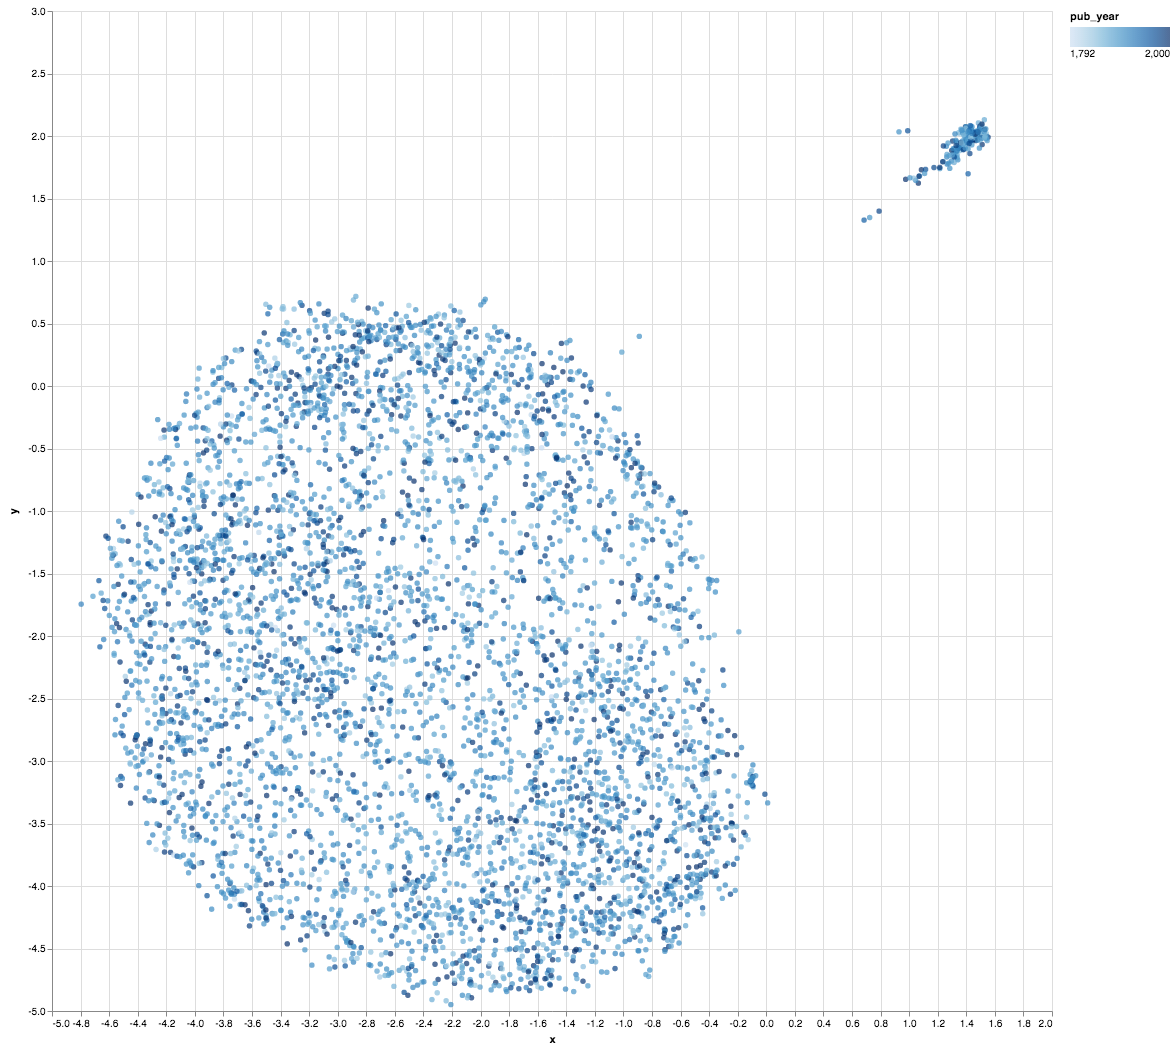

In [173]:
chart.interactive()